# Exploratory Data Analysis

# Preprocessing once

In [3]:
# Remove irrelevant features prior to preprocessing
del yelp_clean['name']
del yelp_clean['latitude']
del yelp_clean['longitude']
#del yelp_clean['geometry'] #run if geopandas code cell was run

## Split the data

In [4]:
# Split the iid data
# Since the data is imbalanced (large number of observations with star rating of 3 & 4),
# we should perform stratified splits to ensure that we get a good number of points from
# each of the target groups.

from sklearn.model_selection import train_test_split 
random_state = 77 #set random state for reproducibility

# Define X and y from yelp_clean
y = yelp_clean['star-rating']
X = yelp_clean.loc[:, (yelp_clean.columns != 'star-rating')].copy()

# Specify categorical columns
cat_cols = ['attributes.RestaurantsPriceRange2','city','state','attributes.BYOB',
   'attributes.RestaurantsGoodForGroups','attributes.RestaurantsAttire',
   'attributes.GoodForDancing','attributes.WheelchairAccessible',
   'attributes.RestaurantsTakeOut','attributes.BusinessAcceptsCreditCards',
   'attributes.ByAppointmentOnly','attributes.CoatCheck','attributes.HasTV',
   'attributes.HappyHour','attributes.Smoking','attributes.OutdoorSeating','is_open',
   'attributes.NoiseLevel','attributes.DriveThru',
   'attributes.RestaurantsReservations','attributes.RestaurantsTableService',
   'attributes.DogsAllowed','attributes.BusinessAcceptsBitcoin',
   'attributes.Alcohol','attributes.Caters','attributes.WiFi',
   'attributes.BYOBCorkage','attributes.Corkage','attributes.AcceptsInsurance',
   'attributes.BikeParking']

# Fill missing data in categorical columns with another category labelled 'missing'
X[cat_cols] = X[cat_cols].fillna(value='missing', axis=0)
# Convert categorical column values to str type
X[cat_cols] = X[cat_cols].astype(str)

# Stratified split of data: 80/10/10
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.8,stratify=y,random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=random_state)

# Print value counts of target variable
print(y_train.value_counts(normalize=True))
print()
print(y_val.value_counts(normalize=True))
print()
print(y_test.value_counts(normalize=True))

4    0.330673
3    0.319881
2    0.164734
5    0.129463
1    0.055250
Name: star-rating, dtype: float64

4    0.330661
3    0.319841
2    0.164714
5    0.129506
1    0.055278
Name: star-rating, dtype: float64

4    0.330699
3    0.319879
2    0.164761
5    0.129443
1    0.055219
Name: star-rating, dtype: float64


In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(142697, 39)
(17837, 39)
(17838, 39)


In [6]:
# Define a "fix" for sklearn's MultiLabelBinarizer to work within a ColumnTransformer
# Source: https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer

from sklearn.base import BaseEstimator, TransformerMixin

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self
    
    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

In [7]:
# Transform categories column into list of lists composed of strings
# We need this format in order to use MultiLabelBinarizer

# Training
yelp_cat_train = X_train['categories']
cat_col_train = []
for row in yelp_cat_train:
    cat_col_train.append(row.split(', '))
# Validation
yelp_cat_val = X_val['categories']
cat_col_val = []
for row in yelp_cat_val:
    cat_col_val.append(row.split(', '))
# Testing
yelp_cat_test = X_test['categories']
cat_col_test = []
for row in yelp_cat_test:
    cat_col_test.append(row.split(', '))
    
# Replace old categories column with the new one

# Training
del X_train['categories']
X_train.loc[:,"categories"] = cat_col_train
# Validation
del X_val['categories']
X_val.loc[:,"categories"] = cat_col_val
# Testing
del X_test['categories']
X_test.loc[:,"categories"] = cat_col_test

In [8]:
# Preprocess X_train, X_val, and X_test

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
np.random.seed(77)

# Collect types of features
ordinal_fts = ['attributes.RestaurantsPriceRange2']
ordinal_cats = [['missing','None','1','2','3','4']]
onehot_fts = ['city','state','attributes.BYOB','attributes.RestaurantsGoodForGroups',
              'attributes.RestaurantsAttire','attributes.GoodForDancing',
              'attributes.WheelchairAccessible','attributes.RestaurantsTakeOut',
              'attributes.BusinessAcceptsCreditCards','attributes.ByAppointmentOnly',
              'attributes.CoatCheck','attributes.HasTV','attributes.HappyHour',
              'attributes.Smoking','attributes.OutdoorSeating','is_open',
              'attributes.NoiseLevel','attributes.DriveThru',
              'attributes.RestaurantsReservations','attributes.RestaurantsTableService',
              'attributes.DogsAllowed','attributes.BusinessAcceptsBitcoin',
              'attributes.Alcohol','attributes.Caters','attributes.WiFi',
              'attributes.BYOBCorkage','attributes.Corkage','attributes.AcceptsInsurance',
              'attributes.BikeParking']
mlb_fts = ['categories']
minmax_fts = ['Monday.hrs.open','Tuesday.hrs.open',
              'Wednesday.hrs.open','Thursday.hrs.open','Friday.hrs.open',
             'Saturday.hrs.open','Sunday.hrs.open']
std_fts = ['review_count']

# Collect encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_fts),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_fts),
        ('minmax', MinMaxScaler(), minmax_fts),
        ('std', StandardScaler(), std_fts),
        ('mlb', MultiHotEncoder(), mlb_fts)],
    n_jobs=-1)
clf = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit transform
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

# Extract feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_fts)) + \
                preprocessor.transformers_[2][-1] + \
                preprocessor.transformers_[3][-1] + \
                [item for sublist in preprocessor.named_transformers_['mlb'].categories_ for item in sublist]

# Convert preprocessed sets to pandas data frames and label preprocessed features
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names)
X_val_prep = pd.DataFrame(X_val_prep, columns=feature_names)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names)

# Print shapes of preprocessed sets
print(X_train_prep.shape)
print(X_val_prep.shape)
print(X_test_prep.shape)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Backshop', 'Market Stalls', 'Mauritius', 'Registry Office', 'Sauna Installation & Repair'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


(142697, 2518)
(17837, 2518)
(17838, 2518)


## Train on one set only to help determine the best evaluation metric and the best ML algorithms. Tune parameters for algorithms that cannot be called in the MLpipe_multiclass function because they are too computationally expensive

In [45]:
from sklearn.utils import class_weight
train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(train_weights)
train_dict = {1: train_weights[0],
             2: train_weights[1],
             3: train_weights[2],
             4: train_weights[3],
             5: train_weights[4]}
print(train_dict)

[3.61991375 1.21408091 0.62523332 0.6048277  1.5448414 ]
{1: 3.619913749365804, 2: 1.2140809120687455, 3: 0.6252333172676686, 4: 0.604827703132285, 5: 1.544841398722529}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=22573     4
80535     4
4486      2
4144      4
153260    5
         ..
29541     2
124001    5
39672     3
91798     3
121948    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [49]:
print(y_test.value_counts())
print()
print("baseline accuracy: ", 5899/sum(y_test.value_counts()))

4    5899
3    5706
2    2939
5    2309
1     985
Name: star-rating, dtype: int64

baseline accuracy:  0.33069850880143514


### K Neighbors - Tune n_neighbors; weights='uniform' (the default) is best

In [36]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

clf_test = KNeighborsClassifier(n_neighbors=50, 
                                n_jobs=-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.4230906684584001

[[ 134  344  329  136   42]
 [ 106  749 1475  503  106]
 [  91  623 3255 1500  237]
 [  32  290 2212 2924  441]
 [  36  137  434 1007  695]]


In [37]:
clf_test = KNeighborsClassifier(n_neighbors=60, 
                                n_jobs=-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.42174439872102276

[[ 134  331  334  141   45]
 [ 108  705 1517  518   91]
 [  83  604 3283 1504  232]
 [  37  288 2224 2941  409]
 [  38  128  423 1032  688]]


In [38]:
clf_test = KNeighborsClassifier(n_neighbors=70, 
                                n_jobs=-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.42162443085499746

[[ 123  332  362  133   35]
 [  99  701 1521  521   97]
 [  74  583 3299 1527  223]
 [  31  279 2240 2954  395]
 [  36  129  433 1026  685]]


### Random Forest - can be tuned with function so only run once here

In [112]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=60, 
                                  n_jobs=-1, 
                                  random_state=7, 
                                  class_weight=train_dict)

# Fit the model on a fraction of the points in order to calculate global feature importance
X_train_sample = X_train_prep[120000:142000]
y_train_sample = y_train[120000:142000]
X_test_sample = X_test_prep[6000:7500]
y_test_sample = y_test[6000:7500]

clf_rf.fit(X_train_sample, y_train_sample)
y_test_pred = clf_rf.predict(X_test_sample)

print(f1_score(y_test_sample, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test_sample, y_test_pred))

0.40867602010644327

[[  7  28  22   9   8]
 [ 17  65 134  50  10]
 [ 14  49 239 187  23]
 [  9  19 134 257  30]
 [  5  11  26  85  62]]


#### Calculate global feature importances with the above model run on a subset of the data. This will not work on the entire test set (it is too large)

#### Permutation importance

In [115]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(clf_rf, X_test_sample, y_test_sample, n_repeats=5, random_state=77, n_jobs=1)

test_names = list(X_test_sample.columns)

forest_importances = pd.Series(perm_imp.importances_mean, index=test_names)
forest_std = pd.Series(perm_imp.importances_std, index=test_names)

In [168]:
imp_labels[::-1]

['attributes.WheelchairAccessible_missing',
 'Local Services',
 'city_Las Vegas',
 'attributes.OutdoorSeating_missing',
 "attributes.Alcohol_u'full_bar'",
 "attributes.Alcohol_u'full_bar'",
 'Hotels & Travel',
 'attributes.BusinessAcceptsBitcoin_False',
 'Tuesday.hrs.open',
 'review_count']

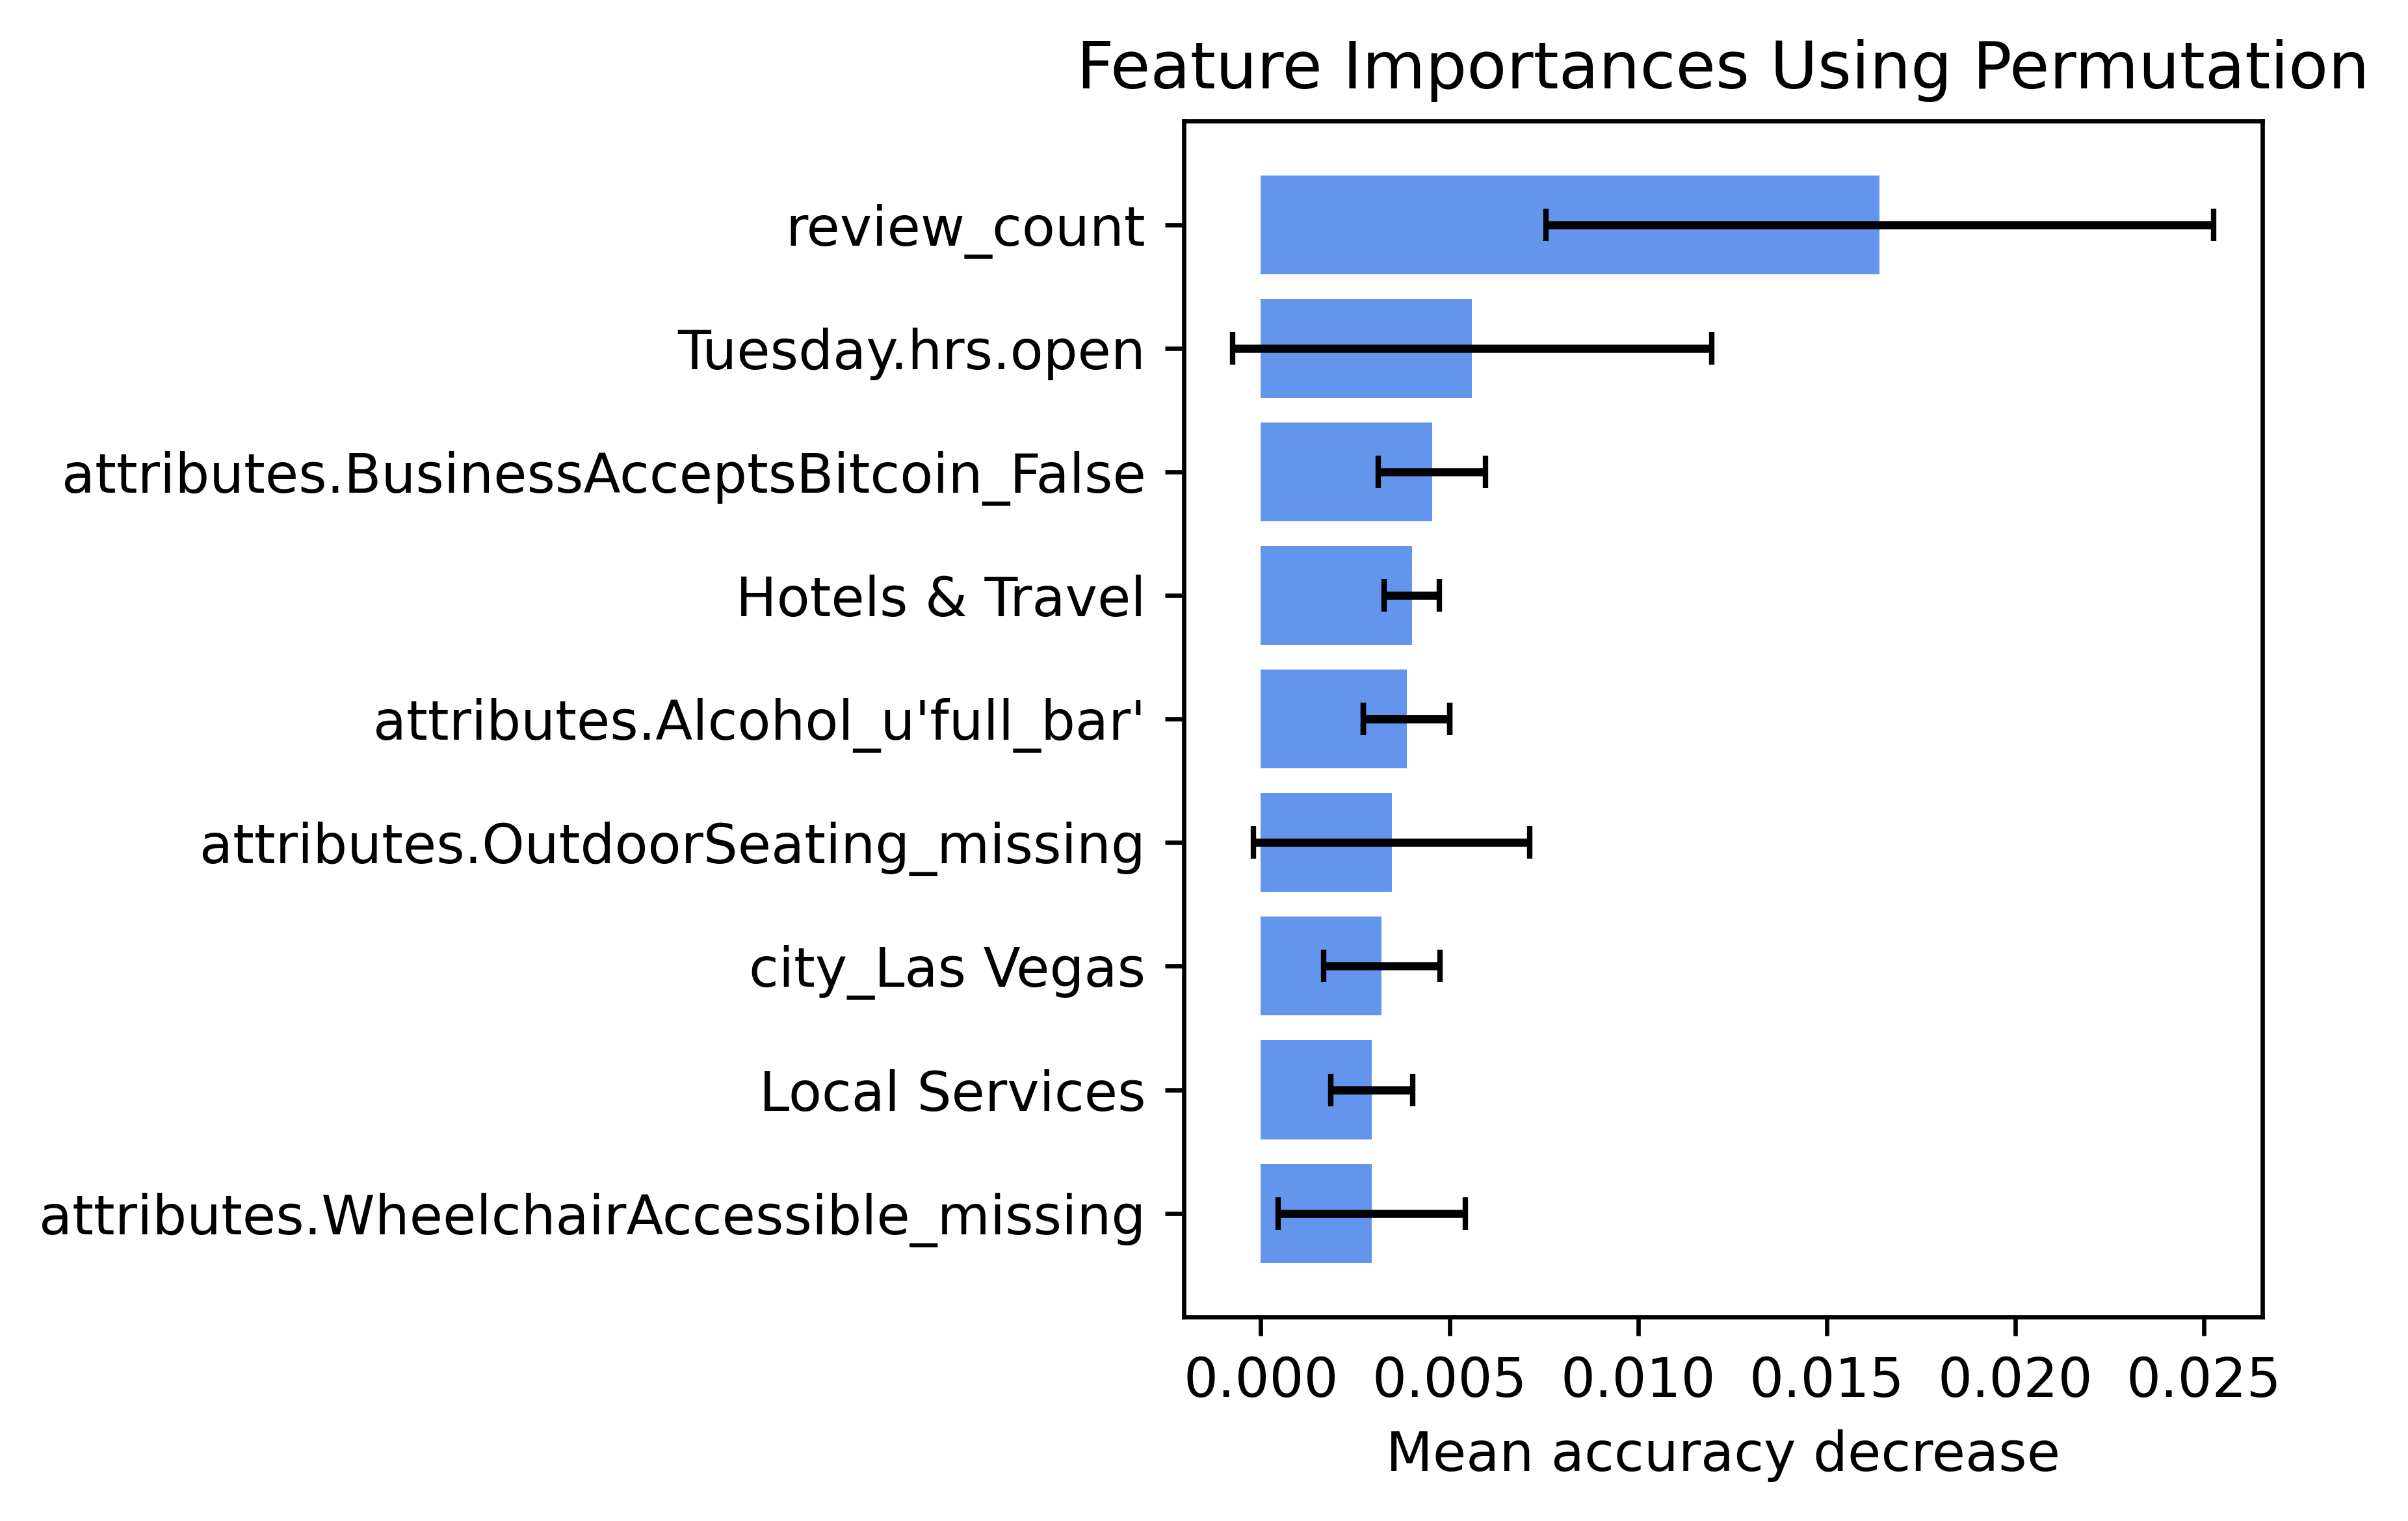

In [189]:
# Take top 10 most important features based on permutation importance on the test set
top10_imp = forest_importances.nlargest(10)
imp_labels = []
for j in range(0,10):
    imp_labels.append(forest_importances[forest_importances==top10_imp[j]].index[0])  
imp_std = []
for l in range(0,10):
    imp_std.append(forest_std[forest_importances==top10_imp[l]][0])

# Plot the most important features
plt.barh(y=imp_labels[::-1], width=top10_imp[::-1], xerr=imp_std[::-1], capsize=3, color='cornflowerblue')
plt.title("Feature Importances Using Permutation")
plt.xlabel("Mean accuracy decrease")
plt.tight_layout()
#plt.savefig('../Figures/permutation-importance.png', bbox_inches='tight')
plt.show()

### Linear SVC - tune C

In [40]:
from sklearn.svm import LinearSVC

#param_grid_svc = {'linearsvc__C': [0.5, 1, 10]}

clf_test = LinearSVC(multi_class='crammer_singer', 
                     class_weight=train_dict, 
                     random_state=77, 
                     max_iter=150000, 
                     C=1e-2, 
                     tol=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.32824262439646334

[[ 642   63   64   61  155]
 [1162  366  468  487  456]
 [1176  500 1043 1870 1117]
 [ 672  273  573 2395 1986]
 [ 255   66   80  235 1673]]


In [42]:
clf_test = LinearSVC(multi_class='crammer_singer', 
                     class_weight=train_dict, 
                     random_state=77, 
                     max_iter=150000, 
                     C=1e-1, 
                     tol=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.33171996667259446

[[ 648   30   95   61  151]
 [1191  196  647  481  424]
 [1199  264 1332 1846 1065]
 [ 715  108  771 2392 1913]
 [ 264   29  116  266 1634]]


In [43]:
clf_test = LinearSVC(multi_class='crammer_singer', 
                     class_weight=train_dict, 
                     random_state=77, 
                     max_iter=150000, 
                     C=1, 
                     tol=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.33136632865213106

[[ 645   52   83   64  141]
 [1190  265  593  473  418]
 [1202  377 1261 1819 1047]
 [ 729  188  735 2350 1897]
 [ 269   44  116  257 1623]]


### Ridge Regression Classifier - tune alpha

In [32]:
from sklearn.linear_model import RidgeClassifier

#param_grid_rc = {'ridgeclassifier__alpha': [1e-3, 1e-2, 1e-1, 1]}

clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.38487042550174916

[[ 579  154   79   45  128]
 [ 990  723  580  274  372]
 [1014  846 1816 1136  894]
 [ 671  426 1049 2091 1662]
 [ 267   97   75  315 1555]]


In [33]:
clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1e-2)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.3850048467300728

[[ 579  154   79   45  128]
 [ 990  723  580  274  372]
 [1014  847 1816 1135  894]
 [ 671  425 1048 2093 1662]
 [ 267   97   75  315 1555]]


In [34]:
clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1e-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.3853486638054189

[[ 579  155   78   45  128]
 [ 990  726  580  272  371]
 [1016  845 1816 1135  894]
 [ 672  424 1050 2093 1660]
 [ 267   97   75  312 1558]]


In [35]:
clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.38563954149410407

[[ 581  154   79   44  127]
 [ 987  724  583  271  374]
 [1015  841 1820 1134  896]
 [ 672  419 1053 2092 1663]
 [ 272   91   75  309 1562]]


# Define a function to apply various machine learning algorithms. Loop through multiple random states & parameters. User can define a K-fold split and apply cross validation if necessary

In [27]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def MLpipe_multiclass(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data into training/validation/testing (80/10/10).
    It loops through 5 different random states.
    It accounts for missing values in categorical features by creating a new category 
    labelled 'missing'. 
    The function takes in a pre-define preprocessor and uses GridSearchCV to tune model
    parameters specific to each ML algorithm run on the data.
    CV is "disabled" within GridSearchCV because of the size of the training set.
    Source: https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning
    '''
    
    num_rand_states = 5
    test_scores = np.zeros(num_rand_states)
    final_models = []
    f1s = []
    
    for i in range(num_rand_states):
        
        np.random.seed(77*i)
        
        # Keep track of which random state we are in (total of 10)
        print("Random state ", i+1)
        
        # Account for missing data in strictly categorical features
        # Specify categorical columns
        cat_cols = ['attributes.RestaurantsPriceRange2','city','state','attributes.BYOB',
                    'attributes.RestaurantsGoodForGroups','attributes.RestaurantsAttire',
                    'attributes.GoodForDancing','attributes.WheelchairAccessible',
                    'attributes.RestaurantsTakeOut','attributes.BusinessAcceptsCreditCards',
                    'attributes.ByAppointmentOnly','attributes.CoatCheck',
                    'attributes.HasTV','attributes.HappyHour','attributes.Smoking',
                    'attributes.OutdoorSeating','is_open','attributes.NoiseLevel',
                    'attributes.DriveThru','attributes.RestaurantsReservations',
                    'attributes.RestaurantsTableService','attributes.DogsAllowed',
                    'attributes.BusinessAcceptsBitcoin','attributes.Alcohol',
                    'attributes.Caters','attributes.WiFi','attributes.BYOBCorkage',
                    'attributes.Corkage','attributes.AcceptsInsurance',
                    'attributes.BikeParking']
        # Fill missing data in categorical columns with another category labelled 'missing'
        X[cat_cols] = X[cat_cols].fillna(value='missing', axis=0)
        # Convert categorical features to str type
        X[cat_cols] = X[cat_cols].astype(str)

        # Stratified split of data: 80/10/10
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, stratify=y, random_state=77*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=77*i)
        
        # Transform categories column into list of lists composed of strings
        # We need this format in order to use MultiLabelBinarizer
        yelp_cat_train = X_train['categories']
        cat_col_train = []
        for row in yelp_cat_train:
            cat_col_train.append(row.split(', '))
        yelp_cat_val = X_val['categories']
        cat_col_val = []
        for row in yelp_cat_val:
            cat_col_val.append(row.split(', '))
        yelp_cat_test = X_test['categories']
        cat_col_test = []
        for row in yelp_cat_test:
            cat_col_test.append(row.split(', '))

        # Replace old categories column with the new one
        del X_train['categories']
        X_train.loc[:,"categories"] = cat_col_train
        del X_val['categories']
        X_val.loc[:,"categories"] = cat_col_val
        del X_test['categories']
        X_test.loc[:,"categories"] = cat_col_test
        
        # Compute class weights for X_train
        train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
        weight_dict = {1: train_weights[0],
                      2: train_weights[1],
                      3: train_weights[2],
                      4: train_weights[3],
                      5: train_weights[4]}
        
        # Define K-fold split with 3 folds
        #kf = KFold(n_splits=3, shuffle=True, random_state=77*i)
        
        # Initialize a classifier; parameters dependent on classifier used
        clf = ML_algo(random_state=77*i, class_weight=weight_dict)
        
        # Create the pipeline, Preprocess the data
        pipe = make_pipeline(preprocessor, clf)
        
        # Use grid search CV; can perform cross validation if cv=kf
        # Currently set to no cross validation
        # Source: https://stackoverflow.com/questions/29503689/how-to-run-gridsearchcv-without-cross-validation/29542887#29542887
        grid = GridSearchCV(pipe, 
                            param_grid=param_grid, 
                            scoring='f1_weighted', #Needs to be maximized
                            cv=ShuffleSplit(test_size=0.20, n_splits=1), #This "disables" CV in GridSearchCV
                            return_train_score=True, 
                            n_jobs=-1, 
                            verbose=True)
        
        # Fit the model on training data
        grid.fit(X_train, y_train)
        
        # Save the results as a data frame
        results = pd.DataFrame(grid.cv_results_)
        
        # Print parameters and score for best model of each iteration
        print('Best model parameters:', grid.best_params_)
        print('Best validation score:', grid.best_score_)
        
        # Append to list of final models
        final_models.append(grid)
        
        # Calculate test scores after model has been fitted
        y_test_pred = final_models[-1].predict(X_test)
        test_scores[i] = f1_score(y_test, y_test_pred, average='weighted') #weighted F1
        print('Weighted F1 test score:', test_scores[i])
        print()
        print(confusion_matrix(y_test, y_test_pred))
        f1s.append(test_scores[i])
    
    # Print mean and standard deviation of 10 best test scores
    print("Mean of test scores: ", np.mean(f1s))
    print("Standard deviation of test scores: ", np.std(f1s))
    
    # Return certain metrics for later (SHAP)
    return grid, final_models, np.array(feature_names), X_test, y_test

## Define preprocessor before calling function

In [14]:
# Define a "fix" for sklearn's MultiLabelBinarizer to work within a ColumnTransformer
# Source: https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self
    
    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result
    
# Collect types of features
ordinal_fts = ['attributes.RestaurantsPriceRange2']
ordinal_cats = [['missing','None','1','2','3','4']]
onehot_fts = ['city','state','attributes.BYOB','attributes.RestaurantsGoodForGroups',
              'attributes.RestaurantsAttire','attributes.GoodForDancing',
              'attributes.WheelchairAccessible','attributes.RestaurantsTakeOut',
              'attributes.BusinessAcceptsCreditCards','attributes.ByAppointmentOnly',
              'attributes.CoatCheck','attributes.HasTV','attributes.HappyHour',
              'attributes.Smoking','attributes.OutdoorSeating','is_open',
              'attributes.NoiseLevel','attributes.DriveThru',
              'attributes.RestaurantsReservations','attributes.RestaurantsTableService',
              'attributes.DogsAllowed','attributes.BusinessAcceptsBitcoin',
              'attributes.Alcohol','attributes.Caters','attributes.WiFi',
              'attributes.BYOBCorkage','attributes.Corkage','attributes.AcceptsInsurance',
              'attributes.BikeParking']
mlb_fts = ['categories']
minmax_fts = ['Monday.hrs.open','Tuesday.hrs.open',
              'Wednesday.hrs.open','Thursday.hrs.open','Friday.hrs.open',
             'Saturday.hrs.open','Sunday.hrs.open']
std_fts = ['review_count']

# Collect encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_fts),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_fts),
        ('minmax', MinMaxScaler(), minmax_fts),
        ('std', StandardScaler(), std_fts),
        ('mlb', MultiHotEncoder(), mlb_fts)],
    n_jobs=-1)

# Extract feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_fts)) + \
                preprocessor.transformers_[2][-1] + \
                preprocessor.transformers_[3][-1] + \
                [item for sublist in preprocessor.named_transformers_['mlb'].categories_ for item in sublist]

## Try a random forest classifier; tune max_depth

In [23]:
# Unable to suppress warnings that MultiLabelBinarizer outputs
# Discussion on fix: https://github.com/scikit-learn/scikit-learn/issues/10410

from sklearn.ensemble import RandomForestClassifier

param_grid_rfc = {
                'randomforestclassifier__max_depth': [50, 55, 60]
                }

MLpipe_multiclass(X, y, preprocessor, RandomForestClassifier, param_grid_rfc)


Random state  1
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=165984    3
103038    4
108520    4
31205     4
152509    4
         ..
53185     3
91153     4
59723     3
28951     3
108100    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Installation', 'Backshop', 'Concept Shops', 'Customs Brokers', 'Experiences', 'Game Meat', 'Minho', 'Pita', 'Sauna Installation & Repair', 'Sikh Temples', 'Tempura', 'Tonkatsu', 'Waldorf Schools'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/s

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.44584679951011374


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Bus Stations', 'Eritrean', 'Hearing Aids', 'Sport Equipment Hire'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4467399369023424

[[ 123  295  324  171   72]
 [ 115  721 1417  538  148]
 [  85  500 3028 1802  291]
 [  38  219 1684 3485  473]
 [  20   99  367  971  852]]
Random state  2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=22573     4
80535     4
4486      2
4144      4
153260    5
         ..
29541     2
124001    5
39672     3
91798     3
121948    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Hall', 'Christmas Markets', 'Elevator Services', 'Experiences', 'Game Meat', 'Hang Gliding', 'Japanese Sweets', 'Milkshake Bars', 'Minho', 'Pita', 'Rodeo', 'Soba', 'Speech Training', 'Swiss Food', 'Toxicologists', 'Wildlife Hunting Ranges'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Hall', 'Christmas Markets', 'Elevator Services', 'Experiences', 'Game Meat', 'Hang Gliding', 'Japanese Sweets', 'Milkshake Bars', 'Minho', 'Pita', 'Rodeo', 'Soba', 'Speech Training', 'Swiss Food', 'Toxicologists', 'Wildlife Hunting Ranges'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.44680658284702696
Weighted F1 test score: 0.44633631862273887

[[ 144  317  301  151   72]
 [ 120  705 1401  572  141]
 [  89  576 2926 1798  317]
 [  35  247 1624 3553  440]
 [  27   91  332  998  861]]
Random state  3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=20282     4
165016    5
145798    4
137264    2
120976    2
         ..
113025    4
102184    4
101366    4
25929     2
108019    4
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Billing Services', 'Hotel bar', 'Japanese Sweets', 'Kitchen Incubators', 'Paragliding', 'Tempura', 'Tonkatsu', 'Toxicologists', 'Trivia Hosts'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Billing Services', 'Hotel bar', 'Japanese Sweets', 'Kitchen Incubators', 'Paragliding', 'Tempura', 'Tonkatsu', 'Toxicologists', 'Trivia Hosts'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Billing Services', 'Hotel bar', 'Japanese Sweets', 'Kitchen Incubators', 'Paragliding', 'Tempura', 'Tonkatsu', 'Toxicologist

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.4511165095965664


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Food Safety Training', 'Hainan', 'Hang Gliding', 'Homeopathic', 'Market Stalls', 'Rodeo'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.44970184124961304

[[ 157  294  327  139   68]
 [ 120  759 1358  561  141]
 [  60  552 2927 1863  304]
 [  29  246 1644 3533  447]
 [  17  106  330  999  857]]
Random state  4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=139823    4
100770    4
143127    2
148735    2
151100    2
         ..
109204    1
129473    2
119866    4
41308     4
165718    4
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Services', 'Beer Garden', 'Bocce Ball', 'Dialysis Clinics', 'Drama Schools', 'Drive-Thru Bars', 'Electricity Suppliers', 'Food Safety Training', 'Homeopathic', 'Hotel bar', 'Milkshake Bars', 'Natural Gas Suppliers', 'Osteopaths', 'Sledding', 'Toxicologists', 'Undersea/Hyperbaric Medicine', 'Waldorf Schools'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Services', 'Beer Garden', 'Bocce Ball', 'Dialysis Clinics', 'Drama Schools', 'Drive-Thru Bars', 'Electricity Suppliers', 'Food Safety Training', 'Homeopathic', 'Hotel bar', 'Milkshake Bars', 'Natural Gas Suppliers', 'Osteopaths', 'Sledding', 'Toxicologists', 'Undersea/Hyperbaric Medicine', 'Wa

Best model parameters: {'randomforestclassifier__max_depth': 55}
Best validation score: 0.447322290493668


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Catalan', 'Stonemasons', 'Tempura', 'Tonkatsu'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4486086506340567

[[ 142  312  324  154   53]
 [ 119  724 1414  535  147]
 [  80  516 2936 1863  311]
 [  34  203 1635 3573  454]
 [  15   80  317 1035  862]]
Random state  5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=58408     5
94642     3
166511    2
161062    4
144810    4
         ..
26840     2
141037    1
26210     3
117599    2
138094    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Garden', 'Billing Services', 'Bungee Jumping', 'Calabrian', 'Concept Shops', 'Hainan', 'Japanese Sweets', 'Kitchen Incubators', 'Nudist', 'Osteopaths', 'Outdoor Movies', 'Sauna Installation & Repair', 'Traditional Clothing'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Garden', 'Billing Services', 'Bungee Jumping', 'Calabrian', 'Concept Shops', 'Hainan', 'Japanese Sweets', 'Kitchen Incubators', 'Nudist', 'Osteopaths', 'Outdoor Movies', 'Sauna Installation & Repair', 'Traditional Clothing'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.4495140912575645


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Bus Stations', 'Carousels', 'Churros', 'Market Stalls', 'Milkshake Bars', 'Pita', 'Trivia Hosts', 'Udon'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4466278054347406

[[ 150  286  332  158   59]
 [ 140  766 1322  576  135]
 [  80  574 2927 1831  294]
 [  34  231 1701 3471  462]
 [  29   91  318 1015  856]]
Mean of test scores:  0.44760291056869833
Standard deviation of test scores:  0.001320365995549412


# The Final Model

In [67]:
# Assume missingness in categorical features has already been accounted for but the data has not been split or preprocessed

final_models= []
test_scores = np.zeros(5)
f1s = []

for i in range(5):
        
    np.random.seed(77*i)
        
    # Keep track of which random state we are in (total of 10)
    print("Random state ", i+1)

    # Stratified split of data: 80/10/10
    X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, stratify=y, random_state=77*i)
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=77*i)
        
    # Transform categories column into list of lists composed of strings
    # We need this format in order to use MultiLabelBinarizer
    yelp_cat_train = X_train['categories']
    cat_col_train = []
    for row in yelp_cat_train:
        cat_col_train.append(row.split(', '))
    yelp_cat_val = X_val['categories']
    cat_col_val = []
    for row in yelp_cat_val:
        cat_col_val.append(row.split(', '))
    yelp_cat_test = X_test['categories']
    cat_col_test = []
    for row in yelp_cat_test:
        cat_col_test.append(row.split(', '))

    # Replace old categories column with the new one
    del X_train['categories']
    X_train.loc[:,"categories"] = cat_col_train
    del X_val['categories']
    X_val.loc[:,"categories"] = cat_col_val
    del X_test['categories']
    X_test.loc[:,"categories"] = cat_col_test
        
    # Compute class weights for X_train
    train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    weight_dict = {1: train_weights[0],
                   2: train_weights[1],
                   3: train_weights[2],
                   4: train_weights[3],
                   5: train_weights[4]}
    
    # Preprocess the data
    preprocessor = ColumnTransformer(
        transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_fts),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_fts),
        ('minmax', MinMaxScaler(), minmax_fts),
        ('std', StandardScaler(), std_fts),
        ('mlb', MultiHotEncoder(), mlb_fts)],
        n_jobs=-1)
    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit transform
    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # Extract feature names
    feature_names = preprocessor.transformers_[0][-1] + \
                    list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_fts)) + \
                    preprocessor.transformers_[2][-1] + \
                    preprocessor.transformers_[3][-1] + \
                    [item for sublist in preprocessor.named_transformers_['mlb'].categories_ for item in sublist]

    # Convert preprocessed sets to pandas data frames and label preprocessed features
    X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names)
    X_val_prep = pd.DataFrame(X_val_prep, columns=feature_names)
    X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names)
    
    # Initialize the final classifier with best parameters
    rf_clf = RandomForestClassifier(random_state=77*i, 
                                    class_weight=weight_dict, 
                                    max_depth=60, 
                                    n_jobs=1)
    
    # Fit the data
    rf_clf.fit(X_train_prep, y_train)
    
    # Save the models
    final_models.append(rf_clf)
    
    # Calculate test scores after model has been fitted
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = f1_score(y_test, y_test_pred, average='weighted')
    print('Weighted F1 test score:', test_scores[i])
    print()
    print(confusion_matrix(y_test, y_test_pred))
    f1s.append(test_scores[i])

Random state  1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=165984    3
103038    4
108520    4
31205     4
152509    4
         ..
53185     3
91153     4
59723     3
28951     3
108100    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Hall', 'General Festivals', 'Hang Gliding', 'Island Pub', 'Milkshake Bars', 'Paragliding', 'Soba', 'Street Art'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['

KeyboardInterrupt: 